### Домашнее задание - Латентное пространство в VAE автоенкодере

Лучше всего читать оригинальные работы - обычно они очень хорошо и подробно написаны.  
Рекомендую прочитать оригинальную статью [Variational AutoEncoder](https://arxiv.org/pdf/1312.6114.pdf) (VAE, D.P. Kingma et. al., 2013)

В данном задании необходимо:

1. Реализовать обычный автоенкодер и VAE автоенкодер с архитектурой как на рисунке:
<img src='images/mnist_vae.png' width=300>

2. Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство, получить рисунок похожий на рисунок ниже для обоих автоенкодеров и сравнить результаты:
<img src='images/vae_mnist_cloud.png' width=300>

3. Построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='images/vae_mnist_digits.png' width=300>

4. (*) Скачать датасет со знаменитостями [celebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) и повторить для него, предварительно (если нужно) сократив размеры картинок, чтобы ускорить работу. Поэкспериментировать с модификацией изображений лиц - например, добавляя очки или изменяя цвет волос.
<img src='images/celeA_intro.png' width=300>

**Замечание** Для того, чтобы реализовать VAE, прочитайте данную ниже небольшаую теоретическую справку и выполните задание в конце.

### Кроссэнтропия
В теории информации перекрёстная энтропия (или *кроссэнтропия*) между двумя распределениями вероятностей измеряет среднее число бит, необходимых для опознания события из набора возможностей, если используемая схема кодирования базируется на заданном распределении вероятностей $q$, вместо «истинного» распределения $p$.  
Кроссэнтропией распределения $q$ по отношению к распределению $p$ называется величина:  
$$H(p, q) \stackrel{\mathrm{df}}{\;=\;} \mathrm{E}_p[-\log q] = -\sum_x p(x)\, \log q(x) = H(p) + D_{KL}(p \| q),$$  
<!-- или  $$H(p, q) = -\int\limits_X p(x)\, \log q(x)\, dx.$$ -->
где $H(p)$ - энтропия распределения $p$, $D_{KL}(p \| q)$ - дивергенция Кульбака-Лейблера. Можно показать, что энтропия $H(p)$ всегда меньше чем кроссэнтропия $H(p, q)$. Таким образом, дивергенция Кульбака-Лейблера - неотрицательная величина.



### Дивергенция Кульбака-Лейблера
Расхождение (дивергенция) Ку́льбака-Ле́йблера (англ. Kullback–Leibler divergence), РКЛ, — информационное расхождение, различающая информация, информационный выигрыш, относительная энтропия (англ. relative entropy). Это неотрицательнозначный функционал, являющийся несимметричной мерой удалённости друг от друга двух вероятностных распределений $p$ и $q$, определённых на общем пространстве элементарных событий:  
$$D_{\mathrm{KL}}(p\parallel q) = \sum_x p(x) \, \log \frac{p(x)}{q(x)} \,$$

### Дивергенция Кульбака-Лейблера для многомерного нормального распределения
Допустим, что мы имеем два многомерных нормальных распределения, со средними $\mu_0, \mu_1$ и с (обратимыми) матрицами ковариаций $\Sigma_0, \Sigma_1$. Если два распределения имеют одинаковую размерность $k$, то РКЛ между распределениями следующее:  
$$D_\text{KL}(\mathcal{N}_0 \parallel  \mathcal{N}_1) = { 1 \over 2 } \left( \mathrm{tr} \left( \Sigma_1^{-1} \Sigma_0 \right) + \left( \mu_1 - \mu_0\right)^\top \Sigma_1^{-1} ( \mu_1 - \mu_0 ) - k + \ln \left( { \det \Sigma_1 \over \det \Sigma_0  } \right)  \right).$$


Упростите данное выражение для случая, которое используется в VAE, когда компоненты векторов независимы, т.е. матрицы ковариации диагональны. Также упростите выражение, когда второе распределение $\mathcal{N}_1$ является стандартным, т.е. с нулевыми средними и единичными дисперсиями.

### Загрузка данных MNIST

In [26]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import  torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
INPUT_SIZE = 784
BATCH_SIZE = 100

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1000, 
                                          shuffle=False)

## MNIST автоенкодер

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, latent_size)
                                  )
    def forward(self, X):
        return self.model(X)

class Decoder(nn.Module):
    def __init__(self,  input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(latent_size, hidden_size),
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, input_size)
                                  )
    def forward(self, X):
        return self.model(X)
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent)

In [28]:
model1 = Autoencoder(input_size=INPUT_SIZE, latent_size=2)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)  

# Train the model
num_epochs = 30
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images
        #labels = labels.to(device)
        
        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/30], Step [100/600], Loss: 0.0595
Epoch [1/30], Step [200/600], Loss: 0.0522
Epoch [1/30], Step [300/600], Loss: 0.0521
Epoch [1/30], Step [400/600], Loss: 0.0469
Epoch [1/30], Step [500/600], Loss: 0.0490
Epoch [1/30], Step [600/600], Loss: 0.0497
Epoch [2/30], Step [100/600], Loss: 0.0506
Epoch [2/30], Step [200/600], Loss: 0.0485
Epoch [2/30], Step [300/600], Loss: 0.0502
Epoch [2/30], Step [400/600], Loss: 0.0481
Epoch [2/30], Step [500/600], Loss: 0.0526
Epoch [2/30], Step [600/600], Loss: 0.0435
Epoch [3/30], Step [100/600], Loss: 0.0449
Epoch [3/30], Step [200/600], Loss: 0.0468
Epoch [3/30], Step [300/600], Loss: 0.0440
Epoch [3/30], Step [400/600], Loss: 0.0461
Epoch [3/30], Step [500/600], Loss: 0.0453
Epoch [3/30], Step [600/600], Loss: 0.0455
Epoch [4/30], Step [100/600], Loss: 0.0441
Epoch [4/30], Step [200/600], Loss: 0.0442
Epoch [4/30], Step [300/600], Loss: 0.0477
Epoch [4/30], Step [400/600], Loss: 0.0455
Epoch [4/30], Step [500/600], Loss: 0.0439
Epoch [4/30

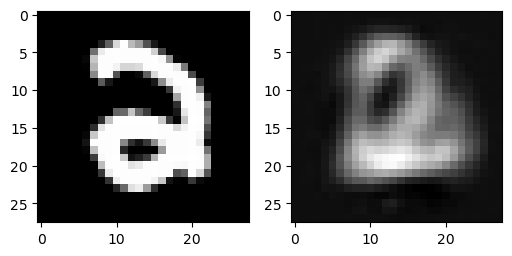

tensor(2)


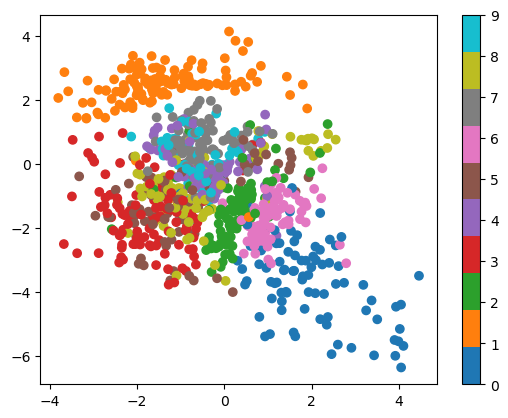

In [ ]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output = model1(images)

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

# fig, axs = plt.subplots(1, 2)#, figsize=(12, 6))
# axs[0].hist(orig_img.flatten(), bins=25)
# axs[1].hist(img.flatten(), bins=25)
# plt.show()

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
latent = model1.encoder(images)
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

## Регуляризация автоенкодера

In [ ]:
class Autoencoder_latent(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent

In [31]:
model2 = Autoencoder_latent(input_size=INPUT_SIZE, latent_size=2)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  
LAMBDA = 0.1
# Train the model
num_epochs = 500
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images
        #labels = labels.to(device)
        
        # Forward pass
        outputs, latent = model2(images)
        reconstruction_loss = criterion(outputs, labels)
        regulizer_loss = (latent * latent).sum(axis=1).mean()
        
        loss = reconstruction_loss + LAMBDA/2 * regulizer_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], reconstruction_loss:{:.6f}, regulizer_loss:{:.6f}, Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, 
                           reconstruction_loss.item(), regulizer_loss.item(), loss.item()))


Epoch [1/500], Step [100/600], reconstruction_loss:0.066009, regulizer_loss:0.026832, Loss: 0.0674
Epoch [1/500], Step [200/600], reconstruction_loss:0.060884, regulizer_loss:0.024612, Loss: 0.0621
Epoch [1/500], Step [300/600], reconstruction_loss:0.056874, regulizer_loss:0.021532, Loss: 0.0580
Epoch [1/500], Step [400/600], reconstruction_loss:0.055536, regulizer_loss:0.016324, Loss: 0.0564
Epoch [1/500], Step [500/600], reconstruction_loss:0.053537, regulizer_loss:0.019277, Loss: 0.0545
Epoch [1/500], Step [600/600], reconstruction_loss:0.055634, regulizer_loss:0.013222, Loss: 0.0563
Epoch [2/500], Step [100/600], reconstruction_loss:0.055124, regulizer_loss:0.012936, Loss: 0.0558
Epoch [2/500], Step [200/600], reconstruction_loss:0.053964, regulizer_loss:0.011670, Loss: 0.0545
Epoch [2/500], Step [300/600], reconstruction_loss:0.055226, regulizer_loss:0.011756, Loss: 0.0558
Epoch [2/500], Step [400/600], reconstruction_loss:0.050396, regulizer_loss:0.010324, Loss: 0.0509
Epoch [2/5

KeyboardInterrupt: 

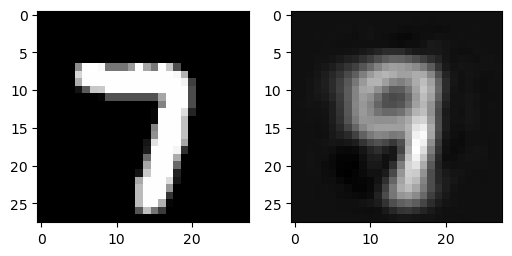

tensor(7)


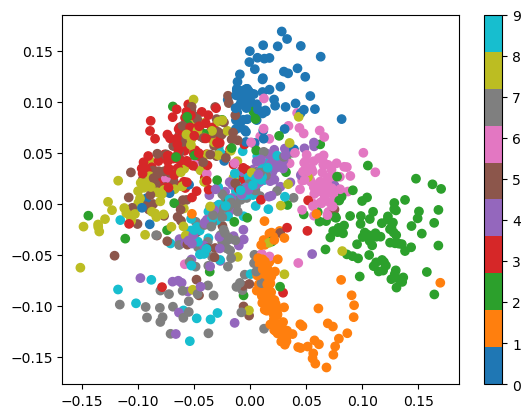

In [32]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

In [33]:
lim = 0.15
xx = np.linspace(-lim, lim, 15)
yy = np.linspace(-lim, lim, 15)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.size, 2)) #np.concatenate((XX[None], YY[None]), axis=0)
ZZ[:,0] = XX.flatten()
ZZ[:,1] = YY.flatten()

latent_gen = torch.FloatTensor(ZZ).to(device)
output = model2.decoder(latent_gen)

In [34]:
images = output.detach().numpy()
big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i*28 : (i+1)*28, j*28 : (j+1)*28] = 1 - images[15*i + j].reshape(28, 28)

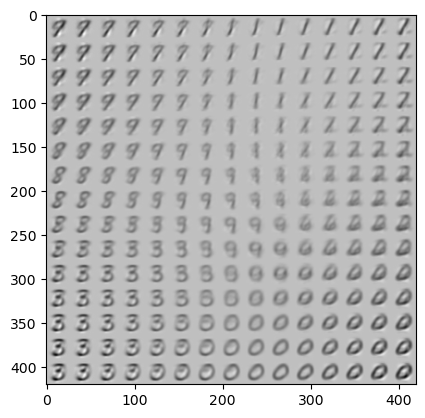

In [35]:
plt.imshow(big_image, cmap='gray')
plt.show()

## VAE автоенкодер

In [36]:
class VariationalEncoder(nn.Module):
    def __init__(self,input_size, latent_dims, hidden_size = 100):
        super(VariationalEncoder,self).__init__()
        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,latent_dims)
        self.linear3 = nn.Linear(hidden_size,latent_dims)

        self.N = torch.distributions.Normal(0,1)
        # self.N.loc = self.N.loc.cuda()
        # self.N.scale = self.N.scale.cuda()
        self.kl = 0
    def forward(self,x):
        # x = torch.flatten(x,start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) -1/2).sum()
        return  z
    
class  VariationalAutoEncoder(nn.Module):
    def __init__(self,input_size, latent_dims,hidden_size = 100):
        super(VariationalAutoEncoder,self).__init__()
        self.encoder = VariationalEncoder(input_size,latent_dims,hidden_size)
        self.decoder = Decoder(input_size,latent_dims, hidden_size)
    
    def forward(self,x):
        z = self.encoder(x)
        return self.decoder(z)

In [37]:
def train(autoencoder, data, epochs=30):
    opt = torch.optim.Adam(autoencoder.parameters())
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        i =0
        for x, y in data:
            x = torch.flatten(x,start_dim=1).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x_hat-x)**2).sum() + autoencoder.encoder.kl
            # print(criterion(x_hat,x))
            loss.backward()
            opt.step()
            i+=1
        print(f"epoch {epoch} batch number {i} loss = {loss}")
    return autoencoder

In [38]:
vae = VariationalAutoEncoder(INPUT_SIZE,latent_dims=2).to(device)
vae = train(vae, train_loader)

epoch 0 batch number 600 loss = 4300.3095703125
epoch 1 batch number 600 loss = 4114.3623046875
epoch 2 batch number 600 loss = 4310.212890625
epoch 3 batch number 600 loss = 4158.03515625
epoch 4 batch number 600 loss = 4330.00341796875
epoch 5 batch number 600 loss = 4097.91162109375
epoch 6 batch number 600 loss = 4123.37548828125
epoch 7 batch number 600 loss = 4231.46337890625
epoch 8 batch number 600 loss = 3964.202880859375
epoch 9 batch number 600 loss = 4081.092529296875
epoch 10 batch number 600 loss = 3970.5576171875
epoch 11 batch number 600 loss = 3763.19384765625
epoch 12 batch number 600 loss = 4077.946044921875
epoch 13 batch number 600 loss = 3840.80126953125
epoch 14 batch number 600 loss = 3971.403564453125
epoch 15 batch number 600 loss = 3688.17626953125
epoch 16 batch number 600 loss = 3848.215576171875
epoch 17 batch number 600 loss = 3888.42333984375
epoch 18 batch number 600 loss = 3922.10546875
epoch 19 batch number 600 loss = 4055.51171875
epoch 20 batch numb

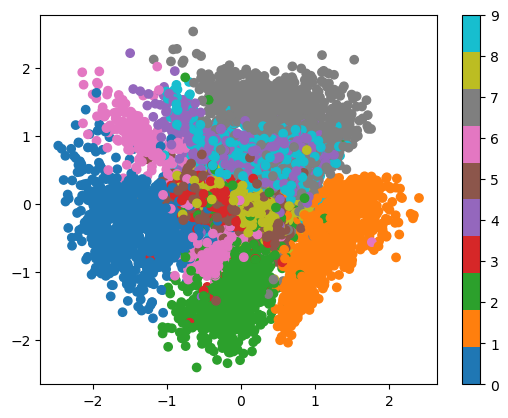

In [41]:
def plot_latent(autoencoder,data,num_batches=100):
    for i ,(x, y) in enumerate(data):
        z = autoencoder.encoder(torch.flatten(x,start_dim=1).to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(vae, train_loader)

In [42]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

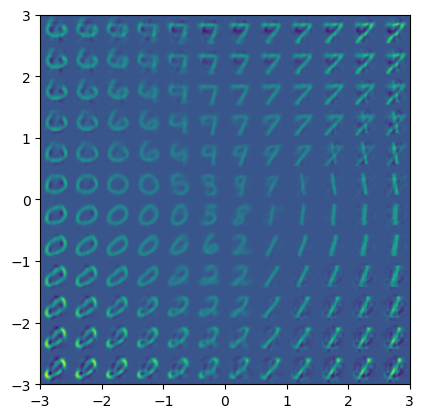

In [43]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))